In [1]:
import ast
import random
import pickle
import json

import pandas as pd
import numpy as np
from numpy.linalg.linalg import LinAlgError
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
import seaborn as sns
from matplotlib_venn import venn2, venn3, venn3_circles
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection
import dateutil
from sklearn.linear_model import LinearRegression
from scipy.stats import chi2

In [2]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

# rename columns to remove '_RBG', '_FBG' for element-wise subtraction
rn.columns = rn.columns.str[:-4]
fn.columns = fn.columns.str[:-4]
ri.columns = ri.columns.str[:-4]
fi.columns = fi.columns.str[:-4]
rd.columns = rd.columns.str[:-4]
fd.columns = fd.columns.str[:-4]

qval_sampling = data['fdr corrected pval effect of sampling']
# qval_sampling.replace(np.nan, 1, inplace=True)  # For replacing blanks (model failed to converge) with 1
qval_gtol = data['fdr corrected pval effect of glucose tolerance']
qval_cross = data['fdr corrected pval effect of interaction sampling and glucose tolerance']

In [3]:
ogtt = pd.read_csv(r'..\data\processed\OGTT_fixed_effects_lm_results.csv', index_col=0)
bg = pd.read_csv(r'..\data\processed\Weekly_BG_fixed_effects_lm_results.csv', index_col=0)

In [4]:
ogtt_values = ap.loc[ap['lcms_sampled'], 'OGTT (AUC)']
min_ogtt, max_ogtt = min(ogtt_values), max(ogtt_values)

def get_model_params(feature, df): 
    params = ast.literal_eval(df.loc[feature]['full_model_params'])
    interceptfbg = params['Intercept']
    interceptrbg = interceptfbg + params['bg_type[T.RBG]']
    minfbg = interceptfbg + params['ogtt'] * min_ogtt
    minrbg = interceptrbg + params['ogtt'] * min_ogtt + params['ogtt:bg_type[T.RBG]'] * min_ogtt
    maxfbg = interceptfbg + params['ogtt'] * max_ogtt
    maxrbg = interceptrbg + params['ogtt'] * max_ogtt + params['ogtt:bg_type[T.RBG]'] * max_ogtt
    
    return {'RBG': [[min_ogtt, max_ogtt], [minrbg, maxrbg]],
            'FBG': [[min_ogtt, max_ogtt], [minfbg, maxfbg]]}  
test = get_model_params('l_222', ogtt)
test

{'RBG': [[846.75, 2321.25], [19.89694449817288, 20.80537257143588]],
 'FBG': [[846.75, 2321.25], [18.95011268332485, 19.465095279545206]]}

In [14]:
data.columns

Index(['Unique ID', 'Type', 'Proposed ID', 'Found in Tracefinder',
       'Compound Class', 'm/z', 'RT [min]', 'Area (Max.)', 'Score', 'Adduct',
       'Polarity', 'pval effect of glucose tolerance',
       'pval effect of sampling',
       'pval effect of interaction sampling and glucose tolerance',
       'fdr corrected pval effect of glucose tolerance',
       'fdr corrected pval effect of sampling',
       'fdr corrected pval effect of interaction sampling and glucose tolerance',
       '1076_10_FBG', '1062_8_FBG', '1093_9_FBG', '1060_8_RBG', '1091_10_FBG',
       '1092_9_RBG', '1093_10_RBG', '1082_10_FBG', '1060_9_RBG', '1101_9_FBG',
       '1062_10_RBG', '1091_8_RBG', '1074_10_FBG', '1101_10_RBG', '1076_9_FBG',
       '1092_9_FBG', '1074_8_FBG', '1091_10_RBG', '1082_9_FBG', '1076_8_RBG',
       '1060_8_FBG', '1093_9_RBG', '1060_10_FBG', '1082_10_RBG', '1074_9_RBG',
       '1091_9_RBG', '1101_10_FBG', '1093_8_FBG', '1074_8_RBG', '1102_10_RBG',
       '1062_9_FBG', '1076_9_RBG', '1

Plasmenyl-PE_P-18:1_22:6_772.52948_8.781
l_352


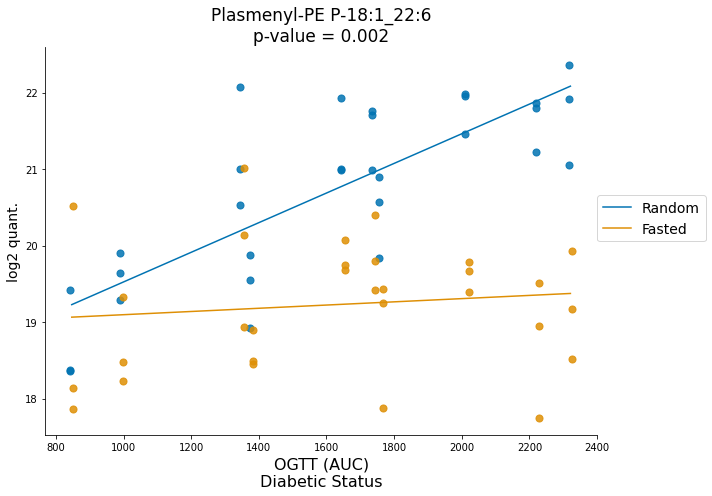

In [96]:
animal_ogtts = ap.loc[ap['lcms_sampled']].filter(regex='OGTT \(AUC\)')

# feature = random.sample(list(data.index), 1)[0]
# feature = 'm_548'
feature = data.loc[(~data['Unique ID'].str.contains('unknown')) & (data['Type'] == 'lipid')]\
              .sort_values(qval_cross.name).iloc[11] 
print(feature['Unique ID'])
feature = feature.name
print(feature)

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
fig.set_facecolor('white')
params = get_model_params(feature, ogtt)

for bg_type, bg_color, offset in zip(['RBG', 'FBG'], [colors['RBG'], colors['FBG']], [-5, 5]):
    ax.plot(params[bg_type][0], params[bg_type][1], color=bg_color,
            label=('Random' if bg_type == 'RBG' else 'Fasted'))
    for animal in animals_used:
        gluc_tol = animal_tol[animal]
        animal_ogtt = animal_ogtts.loc[animal]
        df = data.loc[feature, data.filter(regex=str(animal)).filter(regex=bg_type).columns]
        plt.scatter(np.array([animal_ogtt]*3) + offset, df, color=bg_color, alpha=0.85, 
                    s=50)
plt.ylabel('log2 quant.', fontsize=14)
plt.xlabel('OGTT (AUC)\nDiabetic Status', fontsize=16)
feature_pvalue = round(data.loc[feature, qval_cross.name], 3)
plt.title(data.loc[feature, 'Proposed ID'] + f'\np-value = {feature_pvalue}', fontsize=17)
plt.legend(loc=(1, 0.5), fontsize=14, markerscale=1.5, )

ylim = ax.get_ylim()
# for ogtt_value in animal_ogtts.iloc[:, 0]:
#     plt.vlines(x=ogtt_value, ymin=ylim[0], ymax=ylim[1], color='gray', alpha=0.2)
# plt.xticks(animal_ogtts.iloc[:, 0])
sns.despine()
plt.tight_layout()
plt.savefig(r'..\reports\figures\tg_182_226_226.png', dpi=300)

Good metablites with small p-val in cross

5: lactic acid
6: Threonine
9: Threonine

In [26]:
round(data.loc[feature, qval_cross.name], 4)

0.0097

trans-Petroselinic acid_281.24793_1.568
m_3


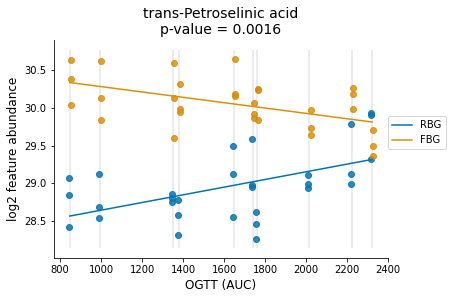

In [48]:
animal_ogtts = ap.loc[ap['lcms_sampled']].filter(regex='OGTT \(AUC\)')

# feature = random.sample(list(data.index), 1)[0]
# feature = 'm_548'
feature = data.loc[~(data['Unique ID'].str.contains('unknown')) & \
                   (data['Type'] == 'metabolite')] \
              .sort_values(qval_cross.name).iloc[2] 
print(feature['Unique ID'])
feature = feature.name
print(feature)

fig, ax = plt.subplots()
fig.set_facecolor('white')
params = get_model_params(feature, ogtt)

for bg_type, bg_color, offset in zip(['RBG', 'FBG'], [colors['RBG'], colors['FBG']], [-5, 5]):
    ax.plot(params[bg_type][0], params[bg_type][1], label=bg_type, color=bg_color)
    for animal in animals_used:
        gluc_tol = animal_tol[animal]
        animal_ogtt = animal_ogtts.loc[animal]
        df = data.loc[feature, data.filter(regex=str(animal)).filter(regex=bg_type).columns]
        plt.scatter(np.array([animal_ogtt]*3) + offset, df, color=bg_color, alpha=0.85)
plt.ylabel('log2 feature abundance', fontsize=12)
plt.xlabel('OGTT (AUC)', fontsize=12)
feature_pvalue = round(data.loc[feature, qval_cross.name], 4)
plt.title(data.loc[feature, 'Proposed ID'] + f'\np-value = {feature_pvalue}', fontsize=14)
plt.legend(loc=(1, 0.5))
ylim = ax.get_ylim()
for ogtt_value in animal_ogtts.iloc[:, 0]:
    plt.vlines(x=ogtt_value, ymin=ylim[0], ymax=ylim[1], color='gray', alpha=0.2)
# plt.xticks(animal_ogtts.iloc[:, 0])
sns.despine()

Lysine_147.11289_17.689
m_234


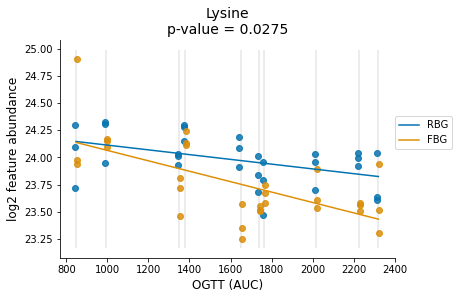

In [67]:


animal_ogtts = ap.loc[ap['lcms_sampled']].filter(regex='OGTT \(AUC\)')

# feature = random.sample(list(data.index), 1)[0]
# feature = 'm_548'
feature = data.loc[~(data['Unique ID'].str.contains('unknown')) & \
                   (data['Type'] == 'metabolite')] \
              .sort_values(qval_gtol.name).iloc[10] 
print(feature['Unique ID'])
feature = feature.name
print(feature)

fig, ax = plt.subplots()
fig.set_facecolor('white')
params = get_model_params(feature, ogtt)

for bg_type, bg_color, offset in zip(['RBG', 'FBG'], [colors['RBG'], colors['FBG']], [-5, 5]):
    ax.plot(params[bg_type][0], params[bg_type][1], label=bg_type, color=bg_color)
    for animal in animals_used:
        gluc_tol = animal_tol[animal]
        animal_ogtt = animal_ogtts.loc[animal]
        df = data.loc[feature, data.filter(regex=str(animal)).filter(regex=bg_type).columns]
        plt.scatter(np.array([animal_ogtt]*3) + offset, df, color=bg_color, alpha=0.85)
plt.ylabel('log2 feature abundance', fontsize=12)
plt.xlabel('OGTT (AUC)', fontsize=12)
feature_pvalue = round(data.loc[feature, qval_gtol.name], 4)
plt.title(data.loc[feature, 'Proposed ID'] + f'\np-value = {feature_pvalue}', fontsize=14)
plt.legend(loc=(1, 0.5))
ylim = ax.get_ylim()
for ogtt_value in animal_ogtts.iloc[:, 0]:
    plt.vlines(x=ogtt_value, ymin=ylim[0], ymax=ylim[1], color='gray', alpha=0.2)
# plt.xticks(animal_ogtts.iloc[:, 0])
sns.despine()

In [6]:
d = {'RBG': {}, 'FBG': {}}

for animal in animals_used:
    for df, bg_type in zip([f, r], ['FBG', 'RBG']):
        bg_type_animal_mean = df.filter(regex=str(animal)).mean(axis=1)
        d['RBG'][animal] = bg_type_animal_mean 
d

{'RBG': {1091: i
  l_0      23.966487
  l_1      24.912942
  l_2      23.413989
  l_3      27.350338
  l_4      22.522382
             ...    
  m_169    25.124559
  m_213    23.324871
  m_24     27.744507
  m_505    21.655395
  m_441    22.617104
  Length: 1727, dtype: float64,
  1093: i
  l_0      23.611918
  l_1      24.567604
  l_2      23.952991
  l_3      26.970232
  l_4      22.766641
             ...    
  m_169    25.198418
  m_213    22.464199
  m_24     27.636194
  m_505    21.183386
  m_441    22.558525
  Length: 1727, dtype: float64,
  1060: i
  l_0      23.840615
  l_1      25.054730
  l_2      24.048209
  l_3      26.942758
  l_4      23.111682
             ...    
  m_169    24.832177
  m_213    21.665979
  m_24     27.396343
  m_505    20.623551
  m_441    22.525861
  Length: 1727, dtype: float64,
  1062: i
  l_0      23.174288
  l_1      23.608273
  l_2      23.749417
  l_3      27.198735
  l_4      22.836285
             ...    
  m_169    24.855207
  m_213    23.623

In [7]:
feature = 'l_557'
test = get_model_fits(feature, ogtt)

plt.plot(test['RBG'][0], test['RBG'][1], c=colors['RBG'], label='random-fed')
plt.plot(test['FBG'][0], test['FBG'][1], c=colors['FBG'], label='fasted')


for bg_type in ['RBG', 'FBG']:
    for animal in animals_used:
        plt.scatter()
    

plt.scatter()

plt.legend()

NameError: name 'get_model_fits' is not defined